Almost everything in the inference study can be considered as doing hypothesis tests. And in most of the cases, any hypothesis $H\in\mathcal{H}$ can be described as the subset of the full parameter space. 

When doing a profiled likelihood test, we factorize the full parameter space as $\Theta\times\Phi$, where $\Theta$ is the space of interesting parameters and $\Phi$ is the space of nuisance parameters which will be always profiled out. Rigorously, for a given interesting parameter $\theta\in\Theta$, the corresponding hypothesis should be written as $H_{\{\theta\}\times\Phi}$ but I will usually be lazy to just call it $H_\theta$. And the test statistic we usually use is defined as 

$$t(X|\theta) = -2\log\frac{L(X|\theta,\hat{\hat{\phi}})}{L(X|\hat{\theta}, \hat{\phi})}$$

where $\hat{\theta}$, $\hat{\phi}$ maximize the likelihood $L$ given observation $X$, and $\hat{\hat{\phi}}(\theta) = \arg\max_{\phi\in\Phi} L(X|\theta, \phi)$. And Wilk's theorem shows that when the sample size is large, $t$ obeys a chi-square distribution asymptotically with degrees of freedom $\dim{\Theta} $.

However this asymptotic condition does not always hold. Following Neyman's construction, the key problem is "if $\theta, \phi$ are the true parameters, what is the distribution of $t$", practically meaning that given $\theta, \phi$ we should simulate $X$ from $H_{\theta,\phi}$ many times and calculate $t(X|\theta)$ to get the distribution. To be clear, only two functions are the keys in the package:

  1. simulate $X$ from $H_{\theta,\phi}$, done by `likelihood.simulate(param)`
  2. calculate $t(X|\theta)$, done by `likelihood.chi2(param, param_profiled_guess)`

Now I will show a simple example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inference as inf

First before anything, we set the `url_base` to be the prefix of the path of any used templates.

In [2]:
inf.set_global_config({'url_base': '/home/zihaoxu/template_v14_SR0/'})

# Define a likelihood

In this example, we consider a 50-GeV WIMP search with ER and NR background, and the likelihood is defined by

$$\begin{aligned}
L(\mathrm{data}|\lambda_{\mathrm{ER}}, \lambda_{\mathrm{NR}}, \lambda_{\mathrm{WIMP}}) &= \mathrm{Poiss}(N|\lambda_{\mathrm{tot}})\times\prod_{i=0}^N\left(\sum_{s\in\{\mathrm{ER, NR, WIMP}\}}\frac{\lambda_s}{\lambda_{\mathrm{tot}}}f_{s,i}\right)\times\mathrm{Gauss}(\lambda_{\mathrm{NR}}|\mu_{\mathrm{NR}}, \sigma_{\mathrm{NR}})
\end{aligned}$$

The definition is already done in `aptinf.demo.testLikelihood` and can be viewed by `likelihood.view()`

In [3]:
likelihood = inf.demo.testLikelihood()
likelihood.view()

Poisson(
	n = len(data)
	lam = 10**lg_nr_rate + 10**lg_er_rate + wimp.norm * 10**lg_sig_mul
)
MultiSourceUnbinnedPDF(
	events = data
	templates = (nr, er, wimp)
	weights = (10**lg_nr_rate, 10**lg_er_rate, wimp.norm * 10**lg_sig_mul)
)
Gaussian(
	x = 10**lg_nr_rate
	mu = nr.norm
	std = nr.norm * nr_rate_relative_std
)


Every time we want to calculate the likelihood, we have to feed the following things. Here `'data'` is also in the `likelihood.param_needed` due to some technical problem but don't confuse yourself.

In [4]:
likelihood.param_needed

{'data', 'lg_er_rate', 'lg_nr_rate', 'lg_sig_mul'}

# Simulate data

To simulate data, we need to input all parameters.

In [5]:
likelihood.set_data_from_toymc({'lg_er_rate': 2,
                                'lg_nr_rate': np.log10(likelihood.nr.norm),
                                'lg_sig_mul': -10})

Then we calculate the max log likelihood. It's stored inside the class since it's slow to compute could be used many times. We suggest to be careful with the initial guess. If the likelihood is very flat near the initial guess, then the optimizer might NOT give the correct function value.

In [6]:
likelihood.set_max_loglikelihood(param_guess={'lg_er_rate': 2,
                                              'lg_nr_rate': np.log10(likelihood.nr.norm),
                                              'lg_sig_mul': 0})

{'lg_er_rate': 1.9664847058736348,
 'lg_nr_rate': -0.3214876392770275,
 'lg_sig_mul': -7.073713030442119}

# Calculate $t$

The profiled log likelihood ratio is called by `likelihood.chi2(param, param_profiled_guess)`.

In [7]:
def t(lg_sig_mul):
    return likelihood.chi2({'lg_sig_mul': lg_sig_mul},
                           {'lg_er_rate': 2, 'lg_nr_rate': 0})

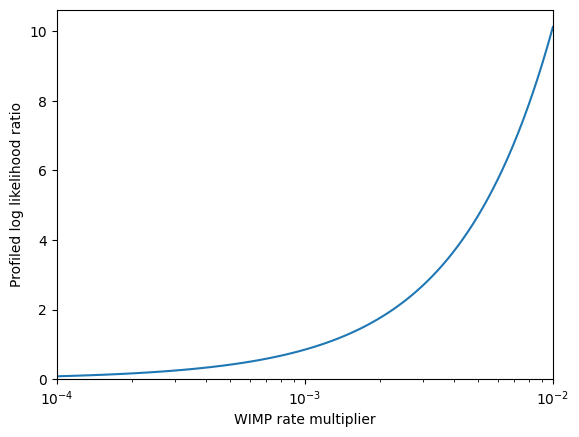

In [8]:
x = np.linspace(-4, -2, 100)
y = [t(xx) for xx in x]

plt.plot(10**x, y)
plt.xscale('log')
plt.xlim(1e-4, 1e-2)
plt.ylim(0, None)
plt.xlabel('WIMP rate multiplier')
plt.ylabel('Profiled log likelihood ratio')
plt.show()